# Guilluy Lab

# LATERAL & MEDIAL DATA

## Nucleus Analysis Overview

This project involves a comprehensive analysis of a dataset containing nuclei observations over multiple frames. The primary goal is to calculate and understand spatial and temporal dynamics of each nucleus, capturing critical metrics that provide insights into their behavior over time. This analysis is structured to be extendable for additional metrics and deeper insights in the future.

### Key Functions and Metrics:

#### `calculate_position_metrics()`
- **Purpose**: Calculates the median frame for each nucleus, identified as `Nucleus_Position`, representing the temporal midpoint of observation for each nucleus.
  
#### `calculate_area_metrics()`
- **Metrics**:
  - `num_frames`: Counts the total frames each nucleus appears in.
  - `max_area`: Records the maximum area covered by the nucleus across all frames.
  - `middle_area`: Measures the area of the nucleus at the median frame.
  - `top_frame_area` & `bottom_frame_area`: Captures the area at the first and last frames, respectively.
  - `sum_area`: Aggregates the total area covered by the nucleus over all observed frames.
  - Additional derived metrics include averages of the top and bottom areas and rate of area change between specified frames.

#### `calculate_perimeter_metrics()`
- **Description**: Calculates metrics related to the perimeter of each nucleus, akin to the area metrics but focused on the outer boundary. This includes maximum, median, top, and bottom perimeter measurements, plus deltas indicating changes between these measurements.

#### `calculate_eop_metrics()` and `calculate_solidity_metrics()`
- **Functions**:
  - **EOP Metrics**: Calculate variations in the perimeter beyond the simple boundary measurements to gauge shape irregularities and complexity.
  - **Solidity Metrics**: Assess the compactness of each nucleus, providing insights into the structural integrity and potential classification based on shape solidity.

#### `plot_nucleus_positions_1d()`
- **Visualization**: This function plots each nucleus based on its calculated `Nucleus_Position`. The visualization serves to map out the temporal observation spread of each nucleus within the dataset, highlighting variations in observation frames across the dataset.
  - **X-axis**: Represents an index for each nucleus.
  - **Y-axis**: Corresponds to the median frame number, illustrating when each nucleus is predominantly observed.

#### `calculate_max_and_median_frames()`
- **New Metrics**:
  - `Max_Area_Frame`: Identifies the frame where each nucleus reaches its maximum area.
  - `Median_Frame`: The median frame across the observed frames, providing a central point of activity for each nucleus.
  - Ensures analysis only includes nuclei with sufficient frame data (at least 10 frames), ensuring robustness in metrics.

These functions collectively offer a robust framework for analyzing nuclei data, providing crucial insights that are pivotal for understanding cellular behaviors and potentially guiding further biological research or experimental planning.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class NucleusAnalysis:
    def __init__(self, excel_file_path):
        self.data = pd.read_excel(excel_file_path)
        self.nucleus_stats = pd.DataFrame()
    def calculate_max_and_median_frames(self):
        # Ensuring the DataFrame for calculations does not have missing 'FRAME' or 'Area (µm²)' values
        temp_df = self.data.dropna(subset=['FRAME', 'Area (µm²)'])

        # Initialize lists for storing calculations
        max_area_frames = []
        median_frames = []
        track_ids_with_enough_frames = []

        # Iterate through the grouped DataFrame
        for track_id, group in temp_df.groupby('TRACK_ID'):
            # Ensure we have at least 10 frames to proceed
            if len(group) >= 10:
                track_ids_with_enough_frames.append(track_id)
                # Calculate and append max area frame
                max_area_frame = group.loc[group['Area (µm²)'].idxmax()]['FRAME']
                max_area_frames.append(max_area_frame)
                # Calculate and append median frame
                median_frame = group['FRAME'].median()
                median_frames.append(median_frame)

        # Creating a temporary DataFrame from the calculations
        temp_results_df = pd.DataFrame({
            'TRACK_ID': track_ids_with_enough_frames,
            'Max_Area_Frame': max_area_frames,
            'Median_Frame': median_frames
        })

        # Merge the temporary results back into nucleus_stats DataFrame
        self.nucleus_stats = pd.merge(self.nucleus_stats, temp_results_df, on='TRACK_ID', how='left')



    def calculate_position_metrics(self):
        # Convert 'POSITION_T' to numeric to ensure median can be calculated
        self.data['POSITION_T'] = pd.to_numeric(self.data['POSITION_T'], errors='coerce')

        # Calculate the median 'POSITION_T' for each 'TRACK_ID', which we consider as the center frame
        center_frame_data = self.data.groupby('TRACK_ID')['POSITION_T'].median().reset_index()
        center_frame_data.rename(columns={'POSITION_T': 'Nucleus_Postion'}, inplace=True)

        # Prepare center_frame_data for merging by setting the index to 'TRACK_ID'
        center_frame_data.set_index('TRACK_ID', inplace=True)

        # Check if nucleus_stats DataFrame already exists and merge the center frame data accordingly
        if not self.nucleus_stats.empty:
            # Merge while preserving all existing columns in nucleus_stats; use outer join to include all TRACK_IDs
            self.nucleus_stats = self.nucleus_stats.merge(center_frame_data, on='TRACK_ID', how='outer')
        else:
            # If nucleus_stats is empty, initialize it with the center_frame_data
            self.nucleus_stats = center_frame_data.reset_index()


    def calculate_area_metrics(self):
        # Group by 'TRACK_ID' and calculate basic stats
        self.nucleus_stats = self.data.groupby('TRACK_ID').agg(
            num_frames=('FRAME', 'nunique'),
            max_area=('Area (µm²)', 'max'),
            sum_area=('Area (µm²)', 'sum')
        ).reset_index()

        # Initialize lists for additional metrics and the new Spot_ID
        middle_areas = []
        top_frame_areas = []
        bottom_frame_areas = []
        top_area_avg = []
        bottom_area_avg = []
        delta_top_median = []
        delta_top_bottom = []
        delta_median_bottom = []
        slope_top_bottom = []
        slope_top_median = []
        slope_median_bottom = []
        spot_ids = []  # List to store Spot_ID of the first frame of each nucleus

        for track_id in self.nucleus_stats['TRACK_ID']:
            # Sort nucleus data by FRAME
            nucleus_data = self.data[self.data['TRACK_ID'] == track_id].sort_values(by='FRAME')
            num_frames = nucleus_data['FRAME'].nunique()

            # Calculate top, middle, and bottom frame areas
            top_area = nucleus_data.head(1)['Area (µm²)'].values[0]
            bottom_area = nucleus_data.tail(1)['Area (µm²)'].values[0]
            middle_area_index = num_frames // 2 if num_frames % 2 == 0 else num_frames // 2
            middle_area = nucleus_data.iloc[middle_area_index]['Area (µm²)']

            # Calculate averages for top and bottom areas
            top_avg = nucleus_data.head(min(3, num_frames))['Area (µm²)'].mean()
            bottom_avg = nucleus_data.tail(min(3, num_frames))['Area (µm²)'].mean()

            # Calculate deltas
            delta_top_median_val = top_area - middle_area
            delta_top_bottom_val = top_area - bottom_area
            delta_median_bottom_val = middle_area - bottom_area

            # Calculate slopes (rate of change)
            frames_for_top_median = middle_area_index if num_frames % 2 == 0 else middle_area_index + 1
            slope_top_bottom_val = delta_top_bottom_val / (num_frames - 1) if num_frames > 1 else 0
            slope_top_median_val = delta_top_median_val / frames_for_top_median if frames_for_top_median > 0 else 0
            slope_median_bottom_val = delta_median_bottom_val / frames_for_top_median if frames_for_top_median > 0 else 0

            # Retrieve the Spot_ID of the first frame
            spot_id_first_frame = nucleus_data.iloc[0]['ID']
            spot_ids.append(spot_id_first_frame)

            # Store all calculated values
            top_frame_areas.append(top_area)
            bottom_frame_areas.append(bottom_area)
            middle_areas.append(middle_area)
            top_area_avg.append(top_avg)
            bottom_area_avg.append(bottom_avg)
            delta_top_median.append(delta_top_median_val)
            delta_top_bottom.append(delta_top_bottom_val)
            delta_median_bottom.append(delta_median_bottom_val)
            slope_top_bottom.append(slope_top_bottom_val)
            slope_top_median.append(slope_top_median_val)
            slope_median_bottom.append(slope_median_bottom_val)

        # Update nucleus_stats DataFrame with the new metrics including the Spot_ID
        self.nucleus_stats['Spot_ID'] = spot_ids
        self.nucleus_stats['middle_area'] = middle_areas
        self.nucleus_stats['top_frame_area'] = top_frame_areas
        self.nucleus_stats['bottom_frame_area'] = bottom_frame_areas
        self.nucleus_stats['top_area_avg'] = top_area_avg
        self.nucleus_stats['bottom_area_avg'] = bottom_area_avg
        self.nucleus_stats['delta_top_median'] = delta_top_median
        self.nucleus_stats['delta_top_bottom'] = delta_top_bottom
        self.nucleus_stats['delta_median_bottom'] = delta_median_bottom
        self.nucleus_stats['slope_top_bottom'] = slope_top_bottom
        self.nucleus_stats['slope_top_median'] = slope_top_median
        self.nucleus_stats['slope_median_bottom'] = slope_median_bottom


    def calculate_perimeter_metrics(self):
        # Initialize lists for perimeter metrics
        top_perimeters = []
        middle_perimeters = []
        bottom_perimeters = []
        max_perimeter = []
        delta_top_median = []
        delta_top_bottom = []
        delta_median_bottom = []

        for track_id in self.nucleus_stats['TRACK_ID']:
            nucleus_data = self.data[self.data['TRACK_ID'] == track_id].sort_values(by='FRAME')

            # Convert 'PERIMETER' to numeric, handling potential non-numeric values gracefully
            nucleus_data['Perimeter (µm)'] = pd.to_numeric(nucleus_data['Perimeter (µm)'], errors='coerce')

            num_frames = nucleus_data['FRAME'].nunique()

            # Calculate top, middle, and bottom perimeters
            top_perimeter = nucleus_data.iloc[0]['Perimeter (µm)']
            bottom_perimeter = nucleus_data.iloc[-1]['Perimeter (µm)']
            max_perimeter.append(nucleus_data['Perimeter (µm)'].max())

            if num_frames % 2 == 0:
                middle_perimeter = (nucleus_data.iloc[(num_frames // 2) - 1]['Perimeter (µm)'] + nucleus_data.iloc[num_frames // 2]['Perimeter (µm)']) / 2
            else:
                middle_perimeter = nucleus_data.iloc[num_frames // 2]['Perimeter (µm)']

            # Store calculated perimeters
            top_perimeters.append(top_perimeter)
            bottom_perimeters.append(bottom_perimeter)
            middle_perimeters.append(middle_perimeter)

            # Calculate and store delta perimeters
            delta_top_median.append(top_perimeter - middle_perimeter)
            delta_top_bottom.append(top_perimeter - bottom_perimeter)
            delta_median_bottom.append(middle_perimeter - bottom_perimeter)

        # Update nucleus_stats DataFrame with the new perimeter metrics
        self.nucleus_stats['max_perimeter'] = max_perimeter
        self.nucleus_stats['top_perimeter'] = top_perimeters
        self.nucleus_stats['middle_perimeter'] = middle_perimeters
        self.nucleus_stats['bottom_perimeter'] = bottom_perimeters
        self.nucleus_stats['delta_perimeter_top_median'] = delta_top_median
        self.nucleus_stats['delta_perimeter_top_bottom'] = delta_top_bottom
        self.nucleus_stats['delta_perimeter_median_bottom'] = delta_median_bottom

    def calculate_eop_metrics(self):
        # Initialize lists for EOP metrics
        max_eop = []
        median_eop = []
        delta_eop_top_median = []
        delta_eop_top_bottom = []
        delta_eop_median_bottom = []

        for track_id in self.nucleus_stats['TRACK_ID']:
            nucleus_data = self.data[self.data['TRACK_ID'] == track_id].sort_values(by='FRAME')

            # Convert 'Excess of Perimeter (EOP)' to numeric
            nucleus_data['Excess of Perimeter (EOP)'] = pd.to_numeric(nucleus_data['Excess of Perimeter (EOP)'], errors='coerce')

            # Calculate max and median EOP
            max_eop.append(nucleus_data['Excess of Perimeter (EOP)'].max())
            median_eop_val = nucleus_data['Excess of Perimeter (EOP)'].median()
            median_eop.append(median_eop_val)

            # Assume that the first and last frame have the top and bottom EOP values respectively
            top_eop = nucleus_data.iloc[0]['Excess of Perimeter (EOP)']
            bottom_eop = nucleus_data.iloc[-1]['Excess of Perimeter (EOP)']

            # Calculate and store delta EOPs
            delta_eop_top_median.append(top_eop - median_eop_val)
            delta_eop_top_bottom.append(top_eop - bottom_eop)
            delta_eop_median_bottom.append(median_eop_val - bottom_eop)

        # Update nucleus_stats DataFrame with the new EOP metrics
        self.nucleus_stats['max_eop'] = max_eop
        self.nucleus_stats['median_eop'] = median_eop
        self.nucleus_stats['delta_eop_top_median'] = delta_eop_top_median
        self.nucleus_stats['delta_eop_top_bottom'] = delta_eop_top_bottom
        self.nucleus_stats['delta_eop_median_bottom'] = delta_eop_median_bottom

    def calculate_solidity_metrics(self):
        # Initialize lists for solidity metrics
        max_solidity = []
        median_solidity = []

        for track_id in self.nucleus_stats['TRACK_ID']:
            nucleus_data = self.data[self.data['TRACK_ID'] == track_id].sort_values(by='FRAME')

            # Convert 'SOLIDITY' to numeric, in case it's not already
            nucleus_data['SOLIDITY'] = pd.to_numeric(nucleus_data['SOLIDITY'], errors='coerce')

            # Calculate max and median SOLIDITY
            max_solidity.append(nucleus_data['SOLIDITY'].max())
            median_solidity.append(nucleus_data['SOLIDITY'].median())

        # Update nucleus_stats DataFrame with the new solidity metrics
        self.nucleus_stats['max_solidity'] = max_solidity
        self.nucleus_stats['median_solidity'] = median_solidity

    def plot_nucleus_positions_1d(self):
        # Check if 'Nucleus_Postion' data is available
        if 'Nucleus_Postion' in self.nucleus_stats.columns:
            # Generate a numeric index for each unique TRACK_ID for plotting
            numeric_indices = np.arange(len(self.nucleus_stats))

            plt.figure(figsize=(14, 8))

            # Apply color variation for visual interest
            colors = plt.cm.viridis(np.linspace(0, 1, len(self.nucleus_stats)))

            # Create scatter plot
            scatter = plt.scatter(numeric_indices, self.nucleus_stats['Nucleus_Postion'],
                                  c=colors, alpha=0.7, edgecolor='k', s=100, cmap='viridis')

            plt.colorbar(scatter, label='Center Frame Index')
            plt.xlabel('Nucleus Index')
            plt.ylabel('Center Frame')
            plt.title('Nucleus Positions Based on Center Frame')

            # Adjust x-ticks to show a label for every 5 or 10 nuclei
            tick_spacing = 5  # or 10, depending on preference
            plt.xticks(numeric_indices[::tick_spacing], self.nucleus_stats['TRACK_ID'][::tick_spacing], rotation=45, ha='right')

            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()  # Adjust layout for readability
            plt.show()
        else:
            print("Center frame data not available. Please calculate it first.")

    def get_stats(self):
        return self.nucleus_stats


Upon initializing the `NucleusAnalysis` with the dataset path, the notebook proceeds to calculate a series of metrics for each nucleus identified within the dataset. These metrics include:

- **Area Metrics**: Aggregates data related to the area occupied by each nucleus across frames, providing insights into their size distribution and changes over Depth.
- **Perimeter Metrics**: Similar to area metrics, but focused on the perimeter of each nucleus, offering another dimension of spatial analysis.
- **Excess of Perimeter (EOP) Metrics**: Analyzes the perimeter's variability, giving an indication of shape complexity or irregularities.
- **Solidity Metrics**: Evaluates the compactness of each nucleus, which can be useful for understanding their physical characteristics and potential classification.
- **Position Metrics** (Assuming `calculate_position_metrics` is akin to `calculate_center_frame`): Determines the central frame for each nucleus, serving as a proxy for its median temporal position in the dataset.

Finally, the `nucleus_stats` DataFrame is compiled, containing all calculated metrics for further analysis or visualization.


# Lateral Dataset Stats & Download the dataframe in Excel Format

In [ ]:
# Update this path to the raw Excel file URL
excel_file_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Lateral_E8-0_export-spots.xlsx'  # Update this path to the location of your Excel file

analysis = NucleusAnalysis(excel_file_path)

# Perform various calculations
analysis.calculate_area_metrics()
analysis.calculate_perimeter_metrics()
analysis.calculate_eop_metrics()
analysis.calculate_solidity_metrics()
analysis.calculate_position_metrics()
analysis.calculate_max_and_median_frames()

nucleus_stats = analysis.get_stats()
nucleus_stats

# Download the dataframe in Excel Format (Lateral)

from google.colab import files

# Assuming nucleus_stats is your DataFrame
output_file_path = 'Lateral_nucleus_analysis_results.xlsx'  # Adjust path as needed
nucleus_stats.to_excel(output_file_path, index=False)

files.download(output_file_path)

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning:

Mean of empty slice



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Position Visualization (Lateral)
plot_nucleus_positions_1d(): Visualizes the position of each nucleus based on its Nucleus_Postion, using a scatter plot. This plot helps in understanding the distribution of nucleus positions across the dataset.

<ipython-input-1-feb7e9bdfbd1>:255: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(numeric_indices, self.nucleus_stats['Nucleus_Postion'],


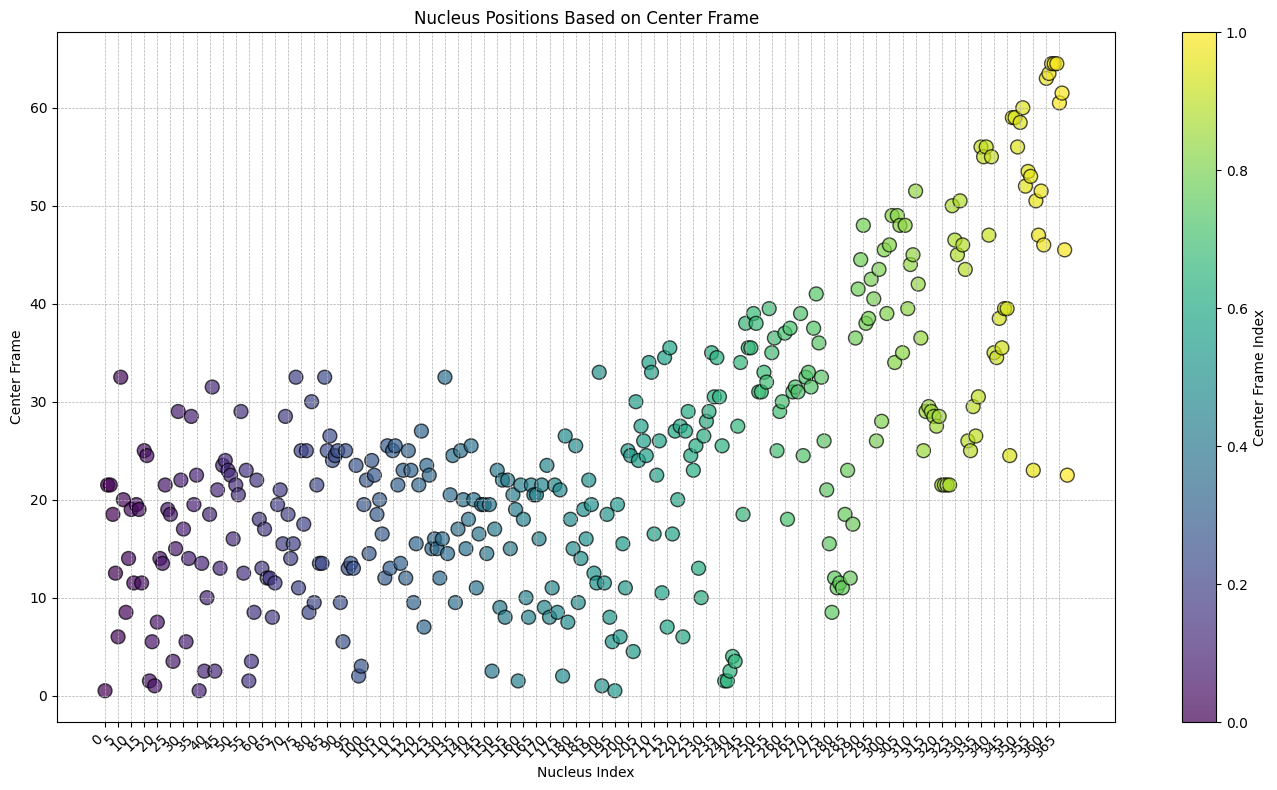

In [ ]:
# This plotting command creates a scatter plot to visualize the central frame position of each nucleus within the dataset.
# The x-axis represents the index of each nucleus, serving as a stand-in for the unique identifier (TRACK_ID) of the nucleus for readability.
# The y-axis denotes the central frame number of each nucleus, calculated as the median frame where the nucleus appears,
# providing an approximation of the nucleus's temporal position within the dataset.
# Each point in the plot corresponds to a nucleus, with its position reflecting the calculated central frame.
# This visualization helps in understanding the distribution of nucleus positions across the dataset's frame range,
# offering insights into the temporal dynamics of nuclei observations.
# The color variation in points enhances visual appeal and differentiation between nuclei.

analysis.plot_nucleus_positions_1d()

# Medial Dataset Stats & Download the dataframe in Excel Format

In [ ]:
# Update this path to the raw Excel file URL
excel_file_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Medial_E8-0_nosplitmerge_export-spots_updated.xlsx'  # Update this path to the location of your Excel file

analysis = NucleusAnalysis(excel_file_path)

# Perform various calculations
analysis.calculate_area_metrics()
analysis.calculate_perimeter_metrics()
analysis.calculate_eop_metrics()
analysis.calculate_solidity_metrics()
analysis.calculate_position_metrics()
analysis.calculate_max_and_median_frames()

nucleus_stats = analysis.get_stats()
nucleus_stats

#Download the dataframe in Excel Format (Medial)
from google.colab import files

# Assuming nucleus_stats is your DataFrame
output_file_path = 'Medial_nucleus_analysis_results.xlsx'  # Adjust path as needed
nucleus_stats.to_excel(output_file_path, index=False)

files.download(output_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


#Position Visualization (Medial)
plot_nucleus_positions_1d(): Visualizes the position of each nucleus based on its Nucleus_Postion, using a scatter plot. This plot helps in understanding the distribution of nucleus positions across the dataset.

<ipython-input-1-feb7e9bdfbd1>:255: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(numeric_indices, self.nucleus_stats['Nucleus_Postion'],


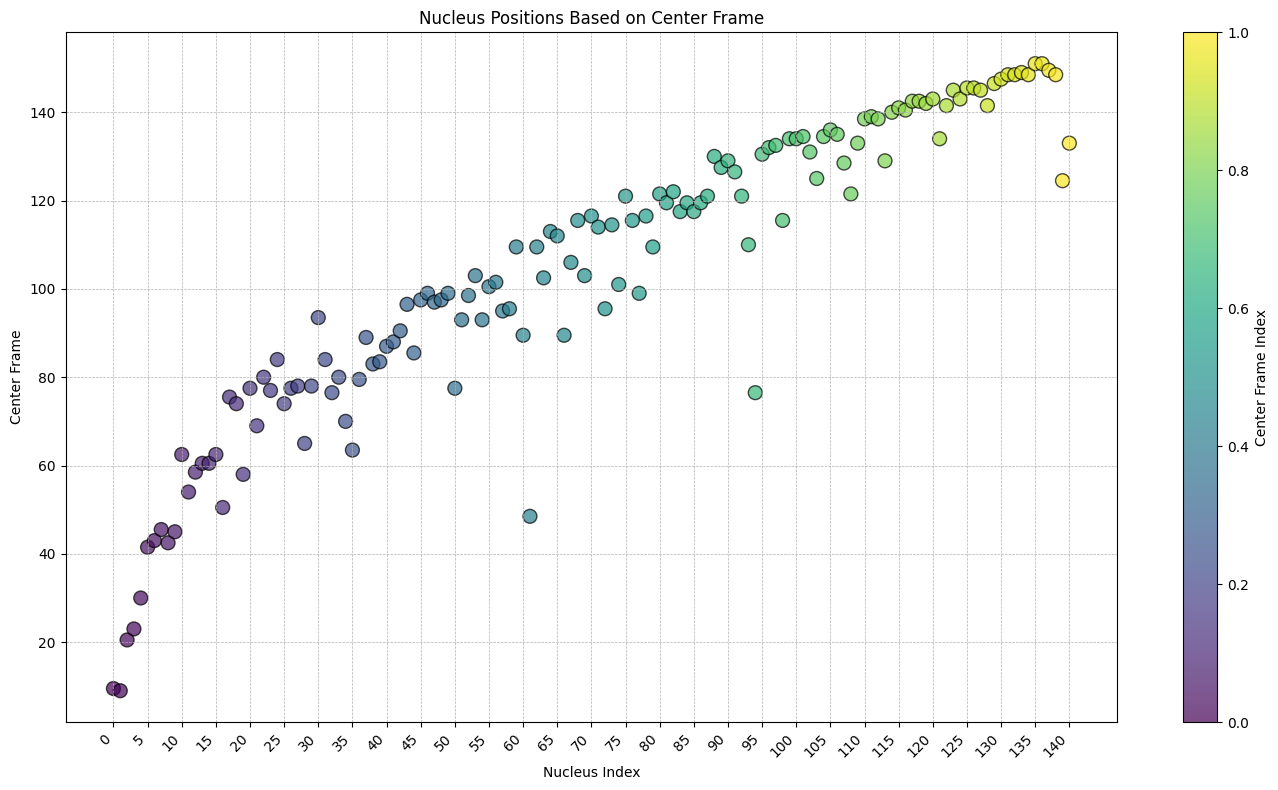

In [ ]:

# This plotting command creates a scatter plot to visualize the central frame position of each nucleus within the dataset.
# The x-axis represents the index of each nucleus, serving as a stand-in for the unique identifier (TRACK_ID) of the nucleus for readability.
# The y-axis denotes the central frame number of each nucleus, calculated as the median frame where the nucleus appears,
# providing an approximation of the nucleus's temporal position within the dataset.
# Each point in the plot corresponds to a nucleus, with its position reflecting the calculated central frame.
# This visualization helps in understanding the distribution of nucleus positions across the dataset's frame range,
# offering insights into the temporal dynamics of nuclei observations.
# The color variation in points enhances visual appeal and differentiation between nuclei.

analysis.plot_nucleus_positions_1d()

# Nucleus Shape Dynamics Clustering
The provided code is a comprehensive approach to categorize the shape dynamics of nuclei based on their area variations over a series of frames. Here's a brief overview of the code and the significance of its output:

1. **Data Loading and Preprocessing:**
   - Nuclei with at least 10 frames are selected to ensure sufficient data for analysis.
   - Deltas (differences in areas) and slopes (rate of change of these areas) are calculated to characterize the shape dynamics of each nucleus.

2. **Feature Standardization:**
   - The features are standardized to have a mean of zero and a standard deviation of one, which is crucial for the performance of many machine learning algorithms, including KMeans.

3. **KMeans Clustering:**
   - The nuclei are then clustered into three groups using KMeans, which is a common clustering algorithm suitable for a broad range of applications.

4. **Visualization:**
   - A scatter plot is generated to visualize the clusters, with the deltas between the top to median area and the median to bottom area as the principal features. This visualization helps in understanding the grouping and the relationship between these features.

5. **Cluster Analysis:**
   - After clustering, each nucleus is assigned a cluster label, and the track IDs are grouped by their respective clusters, facilitating further biological analysis.

6. **Significance:**
   - The clusters may reflect shared growth patterns or developmental stages, providing insights into the morphological changes of the nuclei. For example, some clusters might represent nuclei that are consistently growing, while others could represent nuclei that are shrinking or undergoing more complex changes.

This analysis, visualized neatly in the scatter plot, offers a strategic summary of nuclei behavior, which is vital for understanding developmental processes. It's an excellent example of applying machine learning to biological data, yielding interpretable and potentially insightful patterns.

# LATERAL DATA CLUSTERING

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset
def load_data():
    excel_file_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Lateral_nucleus_analysis_results.xlsx'  # Update this path
    return pd.read_excel(excel_file_path)

# Preprocessing function to prepare data for clustering
def preprocess_for_clustering(nucleus_data):
    # Filter nuclei with frames >= 10
    filtered_data = nucleus_data[nucleus_data['num_frames'] >= 10]

    # Calculate deltas and slopes
    filtered_data['delta_top_median'] = filtered_data['top_frame_area'] - filtered_data['middle_area']
    filtered_data['delta_top_bottom'] = filtered_data['top_frame_area'] - filtered_data['bottom_frame_area']
    filtered_data['delta_median_bottom'] = filtered_data['middle_area'] - filtered_data['bottom_frame_area']
    filtered_data['slope_top_median'] = filtered_data['delta_top_median'] / filtered_data['num_frames']
    filtered_data['slope_top_bottom'] = filtered_data['delta_top_bottom'] / filtered_data['num_frames']
    filtered_data['slope_median_bottom'] = filtered_data['delta_median_bottom'] / filtered_data['num_frames']

    # Select features for clustering
    features = ['delta_top_median', 'delta_top_bottom', 'delta_median_bottom',
                'slope_top_median', 'slope_top_bottom', 'slope_median_bottom']
    X = filtered_data[features].dropna()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, filtered_data, features

# Clustering function
def perform_clustering(X_scaled):
    # Cluster using KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    return labels

# Visualization function for clustering results
def visualize_clusters(filtered_data, labels, features):
    # Incorporate cluster labels into the dataframe
    filtered_data['cluster'] = labels

    # Plot using Plotly for an interactive scatter plot
    fig = px.scatter(filtered_data, x=features[0], y=features[2], color='cluster',
                     labels={'color': 'Cluster'},
                     hover_data=features + ['TRACK_ID'],
                     title='Interactive Clustering of Nucleus Shapes')
    fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))
    fig.show()

    return filtered_data

# Main function to execute clustering and visualization
def main_clustering_and_visualization():
    nucleus_data = load_data()
    X_scaled, filtered_data, features = preprocess_for_clustering(nucleus_data)
    labels = perform_clustering(X_scaled)
    filtered_data = visualize_clusters(filtered_data, labels, features)

    # Group by clusters and print the track IDs
    cluster_groups = filtered_data.groupby('cluster')['TRACK_ID'].apply(list)
    for cluster, tracks in cluster_groups.items():
        print(f"Cluster {cluster}: {tracks}")

# Run the main function
main_clustering_and_visualization()


<ipython-input-28-c8e5f2bd1885>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-c8e5f2bd1885>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-c8e5f2bd1885>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-28-c8e5

Cluster 0: [1, 2, 3, 13, 16, 21, 23, 28, 29, 33, 35, 41, 45, 46, 48, 50, 51, 54, 67, 69, 70, 77, 81, 86, 87, 92, 96, 99, 100, 102, 103, 104, 108, 111, 112, 116, 120, 121, 123, 124, 133, 135, 137, 140, 141, 145, 149, 152, 154, 159, 160, 164, 165, 167, 172, 176, 178, 180, 183, 187, 192, 193, 199, 200, 201, 204, 205, 206, 208, 214, 217, 218, 219, 220, 223, 225, 226, 227, 230, 231, 233, 236, 243, 245, 246, 247, 249, 250, 251, 253, 254, 255, 257, 259, 260, 263, 264, 268, 270, 273, 274, 287, 288, 290, 291, 292, 293, 294, 299, 304, 309, 339]
Cluster 1: [4, 5, 7, 8, 10, 11, 12, 14, 18, 20, 22, 25, 27, 30, 31, 32, 34, 37, 39, 40, 43, 44, 49, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 75, 76, 78, 79, 80, 82, 83, 90, 91, 93, 94, 95, 101, 105, 106, 107, 109, 113, 115, 118, 119, 125, 126, 127, 129, 131, 132, 134, 136, 138, 139, 142, 143, 146, 147, 150, 151, 153, 155, 156, 157, 161, 162, 163, 166, 168, 169, 170, 171, 173, 174, 177, 179, 181, 182, 184, 185, 186, 188, 196, 198, 20

# MEDIAL DATA CLUSTERING

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load the dataset
def load_data():
    excel_file_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Medial_nucleus_analysis_results.xlsx'  # Update this path
    return pd.read_excel(excel_file_path)

# Preprocessing function to prepare data for clustering
def preprocess_for_clustering(nucleus_data):
    # Filter nuclei with frames >= 10
    filtered_data = nucleus_data[nucleus_data['num_frames'] >= 10]

    # Calculate deltas and slopes
    filtered_data['delta_top_median'] = filtered_data['top_frame_area'] - filtered_data['middle_area']
    filtered_data['delta_top_bottom'] = filtered_data['top_frame_area'] - filtered_data['bottom_frame_area']
    filtered_data['delta_median_bottom'] = filtered_data['middle_area'] - filtered_data['bottom_frame_area']
    filtered_data['slope_top_median'] = filtered_data['delta_top_median'] / filtered_data['num_frames']
    filtered_data['slope_top_bottom'] = filtered_data['delta_top_bottom'] / filtered_data['num_frames']
    filtered_data['slope_median_bottom'] = filtered_data['delta_median_bottom'] / filtered_data['num_frames']

    # Select features for clustering
    features = ['delta_top_median', 'delta_top_bottom', 'delta_median_bottom',
                'slope_top_median', 'slope_top_bottom', 'slope_median_bottom']
    X = filtered_data[features].dropna()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, filtered_data, features

# Clustering function
def perform_clustering(X_scaled):
    # Cluster using KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    return labels

# Visualization function for clustering results
def visualize_clusters(filtered_data, labels, features):
    # Incorporate cluster labels into the dataframe
    filtered_data['cluster'] = labels

    # Plot using Plotly for an interactive scatter plot
    fig = px.scatter(filtered_data, x=features[0], y=features[2], color='cluster',
                     labels={'color': 'Cluster'},
                     hover_data=features + ['TRACK_ID'],
                     title='Interactive Clustering of Nucleus Shapes')
    fig.update_traces(marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')))
    fig.show()

    return filtered_data

# Main function to execute clustering and visualization
def main_clustering_and_visualization():
    nucleus_data = load_data()
    X_scaled, filtered_data, features = preprocess_for_clustering(nucleus_data)
    labels = perform_clustering(X_scaled)
    filtered_data = visualize_clusters(filtered_data, labels, features)

    # Group by clusters and print the track IDs
    cluster_groups = filtered_data.groupby('cluster')['TRACK_ID'].apply(list)
    for cluster, tracks in cluster_groups.items():
        print(f"Cluster {cluster}: {tracks}")

# Run the main function
main_clustering_and_visualization()


<ipython-input-23-1aec66e1467b>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-1aec66e1467b>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-1aec66e1467b>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-23-1aec

Cluster 0: [0, 19, 60, 103, 125]
Cluster 1: [2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 62, 63, 64, 65, 67, 68, 70, 71, 73, 75, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 97, 99, 104, 107, 109, 140]
Cluster 2: [1, 8, 22, 34, 54, 69, 78, 79, 92, 95, 96, 100, 101, 102, 105, 106, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 123, 126, 127, 129]


# Interactive Analysis of Nuclei Max Area Frame vs. Median Frame (Lateral and Medial)
The scatter plot correlates the frame with the maximum cross-sectional area of a nucleus to the median frame in its sequence. Since the frames capture different depths or stages, this visualization shows where along the Z-axis or time series each nucleus reaches its maximum size relative to its median position:

- **Below Diagonal**: Nuclei whose maximum size occurs before the median frame, suggesting they may taper off or become narrower in subsequent frames.
- **Above Diagonal**: Nuclei whose maximum size is observed after the median frame, indicating they may be initially narrower and then expand.
- **On Diagonal**: Nuclei with maximum size at the median frame, suggesting a symmetrical structure or growth pattern in the sequence.

This plot essentially maps out the shape dynamics of nuclei across their depth or temporal sequence, which is critical for understanding their structural characteristics and any potential functional implications.
# **NOTE:** <br>
For Lateral I have taken nuclues with Frame >=10 <br>
For Medial I have taken nuclues with Frame >=7


In [ ]:
import plotly.express as px
import pandas as pd

# Load your datasets
# Replace 'path_to_your_lateral_dataset.xlsx' and 'path_to_your_medical_dataset.xlsx' with the actual file paths
lateral_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Lateral_nucleus_analysis_results.xlsx'
medial_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Medial_nucleus_analysis_results.xlsx'

lateral_data = pd.read_excel(lateral_path)
medial_data = pd.read_excel(medial_path)

# Filter data based on the frame condition
lateral_data_filtered = lateral_data[lateral_data['num_frames'] >= 10]
medial_data_filtered = medial_data[medial_data['num_frames'] >= 7]
# Add a new column to distinguish between datasets
lateral_data_filtered['Dataset'] = 'Lateral'
medial_data_filtered['Dataset'] = 'Medial'

combined_data = pd.concat([lateral_data_filtered, medial_data_filtered])

# Adjusting opacity and marker size for clarity
fig = px.scatter(combined_data, x='Median_Frame', y='Max_Area_Frame',
                 color='Dataset', hover_data=['TRACK_ID'],
                 labels={'Median_Frame': 'Median Frame', 'Max_Area_Frame': 'Max Area Frame'},
                 title='Interactive Analysis of Nuclei Max Area Frame vs. Median Frame',
                 opacity=0.5, size_max=10) # Adjusted opacity and size_max for clarity

# Add a line where Max Area Frame equals Median Frame for reference
fig.add_shape(type='line', x0=0, y0=0, x1=combined_data['Median_Frame'].max(), y1=combined_data['Max_Area_Frame'].max(),
              line=dict(color='Red', dash='dash'), name='Max Area = Median Frame')

# Enhance layout with zoom and pan tools enabled by default in Plotly
fig.update_layout(legend_title_text='Dataset', dragmode='pan')

# Show the plot
fig.show()

<ipython-input-29-6397f0909b3b>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-29-6397f0909b3b>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##Conclusion
This project provides a comprehensive analysis of nuclei characteristics within a dataset, leveraging a structured approach to calculate and visualize key spatial and temporal metrics. Through these metrics, the project offers valuable insights into the dynamics and properties of observed nuclei

# **CALCULATE EXCESS PARAMETERS**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files

class ParameterCalculator:
    def __init__(self, pixel_width):
        self.pixel_width = pixel_width
        self.pixel_width_squared = self.pixel_width ** 2

    def calculate_area(self, area_parameter):
        return area_parameter * self.pixel_width_squared

    def calculate_radius(self, area):
        return np.sqrt(area / np.pi)

    def calculate_perimeter_perfect_circle(self, radius):
        return 2 * np.pi * radius

    def calculate_perimeter(self, perimeter_parameter):
        return perimeter_parameter * self.pixel_width

    def calculate_eop(self, perimeter, perimeter_perfect_circle):
        return (perimeter - perimeter_perfect_circle) / perimeter_perfect_circle

# Replace with the path to your dataset
dataset_path = 'https://raw.githubusercontent.com/adityachitlangia/Nucleus-Analysis-Guilluy-Lab-/main/Data/Medial_E8-0_nosplitmerge_export-spots.xlsx'  # Adjusted for a more general path

# Load the dataset from the Excel file
df = pd.read_excel(dataset_path)

# Convert 'AREA' and 'PERIMETER' columns to float
df['AREA'] = pd.to_numeric(df['AREA'], errors='coerce')
df['PERIMETER'] = pd.to_numeric(df['PERIMETER'], errors='coerce')

# Drop rows with NaN values
df = df.dropna(subset=['AREA', 'PERIMETER'])

# Initialize the calculator with the given pixel width
calculator = ParameterCalculator(pixel_width=0.3125849)

# Calculate extra parameters
df['Area (µm²)'] = calculator.calculate_area(df['AREA'])
df['Radius of Perfect Circle'] = calculator.calculate_radius(df['Area (µm²)'])
df['Perimeter of Perfect Circle'] = calculator.calculate_perimeter_perfect_circle(df['Radius of Perfect Circle'])
df['Perimeter (µm)'] = calculator.calculate_perimeter(df['PERIMETER'])
df['Excess of Perimeter (EOP)'] = calculator.calculate_eop(df['Perimeter (µm)'], df['Perimeter of Perfect Circle'])

# Save the updated dataframe to a new Excel file
output_file_path = 'Medial_E8-0_nosplitmerge_export-spots_updated.xlsx'
df.to_excel(output_file_path, index=False)

# Download the file to your local system
files.download(output_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>